In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import matplotlib.colors as mcolors
import networkx as nx
import pickle

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc, cost_functions
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_nw

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2


options = {
    'node_color': 'lightgray',
    'node_size': 1000,
    'width': 2,
    'arrowstyle': '-|>',
    'arrowsize': 20,
    'font_size' : 20,
    'font_weight' : 'bold',
    }

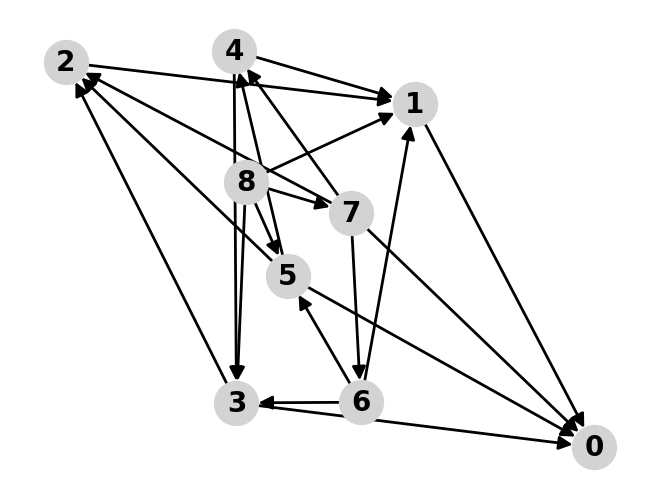

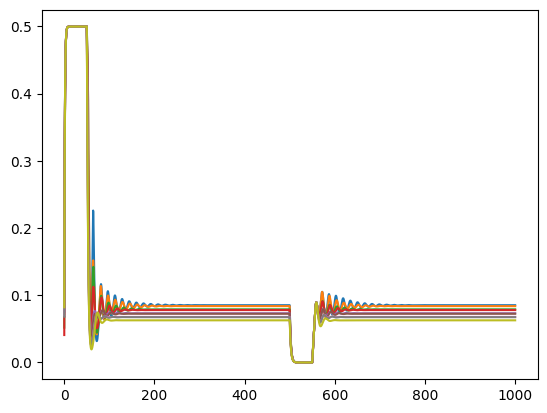

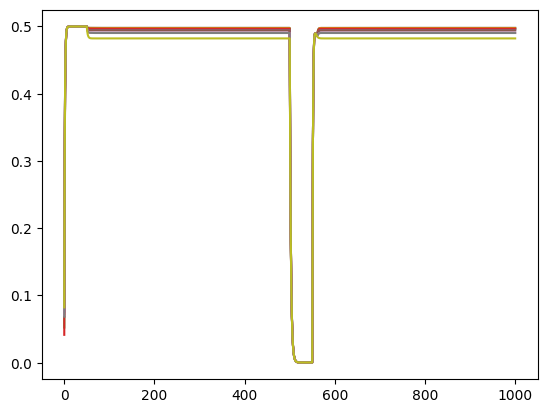

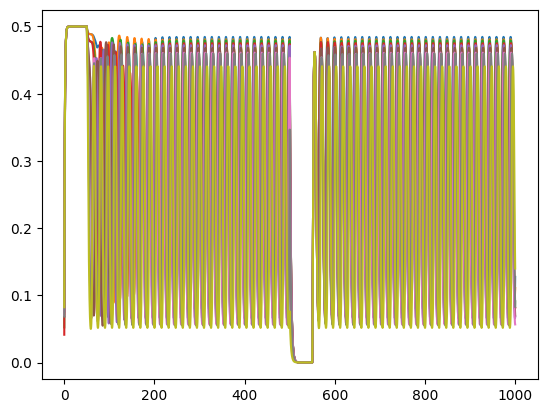

period =  15.647368421052633


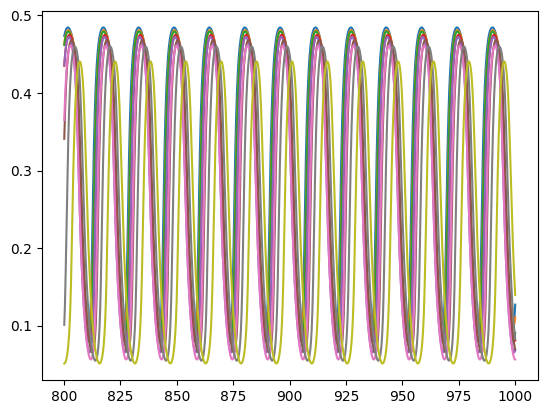

In [2]:
comp_points = [[1., 0.5], [3., 0.5], [2., 0.5]]

cmat = np.array(  [[0, 1, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]
)
dmat = 10. * cmat.copy()
N = cmat.shape[0]
dir = "images_9n_tol"


G = nx.DiGraph() 
for n in range(cmat.shape[0]):
        for l in range(cmat.shape[1]):
            if cmat[n,l] != 0:
                G.add_edge(l,n)
nx.draw(G, with_labels=True, arrows=True, **options)
plt.savefig(os.path.join(dir, "network.png"), bbox_inches='tight')
plt.show()

colors = []
n = 0
for col in mcolors.TABLEAU_COLORS:
    colors.append(col)
    n += 1
    if n >= N: break

model = WCModel(Cmat=cmat, Dmat=dmat)

dt = 0.1
model.params['dt'] = dt # Integration time step, ms
model.params['duration'] = 1. * 1000 # Simulation time, ms
model.params.signalV = 1.

zero_input = ZeroInput().generate_input(duration=model.params['duration']+model.params.dt, dt=model.params.dt)
rect_input = np.vstack( (zero_input)*2 )
rect_input[0,:500] = 5.
rect_input[0,5000:5500] = -5.

for p in comp_points:
    model.params["exc_ext"] = p[0] + rect_input[0,:]
    model.params["inh_ext"] = p[1]
    model.run()

    for n in range(N):
        plt.plot(model.t, model.exc[n,:], color=colors[n])
    plt.show()

    if p[0] == 2.:

        peaks = scipy.signal.find_peaks(model.exc[0,2000:5000])[0]
        plist = []
        for pind in range(1, len(peaks)):
            plist.append(model.params.dt * (peaks[pind]-peaks[pind-1]))

        period = np.mean(plist)
        print("period = ", period)

        peaksn = [None]*N

        for n in range(N):
            peaksn[n] = scipy.signal.find_peaks(model.exc[n,4000:5000])[0]

        for n in range(N):
            plt.plot(model.t[8000:10000], model.exc[n,8000:10000], color=colors[n])
        plt.show()

In [3]:
def getperiods(x, prominence):
    timing_list = [None] * N
    periods_list = [None] * N

    for n in range(N):
        timing_list[n] = scipy.signal.find_peaks(x[n, 0, 300:], prominence=prominence)[0]
        periods_list[n] = []
        if len(timing_list[n]) < 3:
            continue
        for pind in range(1, len(timing_list[n])):
            periods_list[n].append(model.params.dt * (timing_list[n][pind]-timing_list[n][pind-1]))

    return timing_list, periods_list

In [6]:
controlmat = np.zeros((N,2))
controlmat[:,0] = 1.

costmat = np.zeros((N, 2))
costmat[:,0] = 1.

duration = 200.
model.params.duration = duration
zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

print(zero_input0.shape, zero_input.shape, zero_control.shape)

w2_array = [1e-3, 1e-5, 1e-7]

results = dict()
results["controls"] = [ [ [None, None, None], [None, None], [None, None], [None, None], [None, None]  ], 
                        [ [None, None], [None, None], [None, None], [None, None], [None, None]  ], 
                        [ [None, None], [None, None], [None, None], [None, None], [None, None]  ], 
]

target_array = [0.5*period, 0.9*period, period, 1.1*period, 1.6*period]
results["periods"] = [ [ [None, None], [None, None], [None, None], [None, None], [None, None]  ], 
                        [ [None, None], [None, None], [None, None], [None, None], [None, None]  ], 
                        [ [None, None], [None, None], [None, None], [None, None], [None, None]  ], 
]
results["timings"] = [ [ [None, None], [None, None], [None, None], [None, None], [None, None]  ], 
                        [ [None, None], [None, None], [None, None], [None, None], [None, None]  ], 
                        [ [None, None], [None, None], [None, None], [None, None], [None, None]  ], 
]

(1, 2001) (1, 2, 2001) (9, 2, 2001)


In [34]:
it = 100
pr = np.arange(0,101,10)
maxstr = 10.
nmaxdel = model.getMaxDelay()
proms = [0.01, 0.001, 0.001]

init_control = zero_control.copy()

pind =  0
pind =  1
pind =  2
itar =  0
iw =  0
iw =  1
iw =  2
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.11215242865625269
Converged in iteration 4 with cost -0.19104777092477998
Final cost : -0.19104777092477998


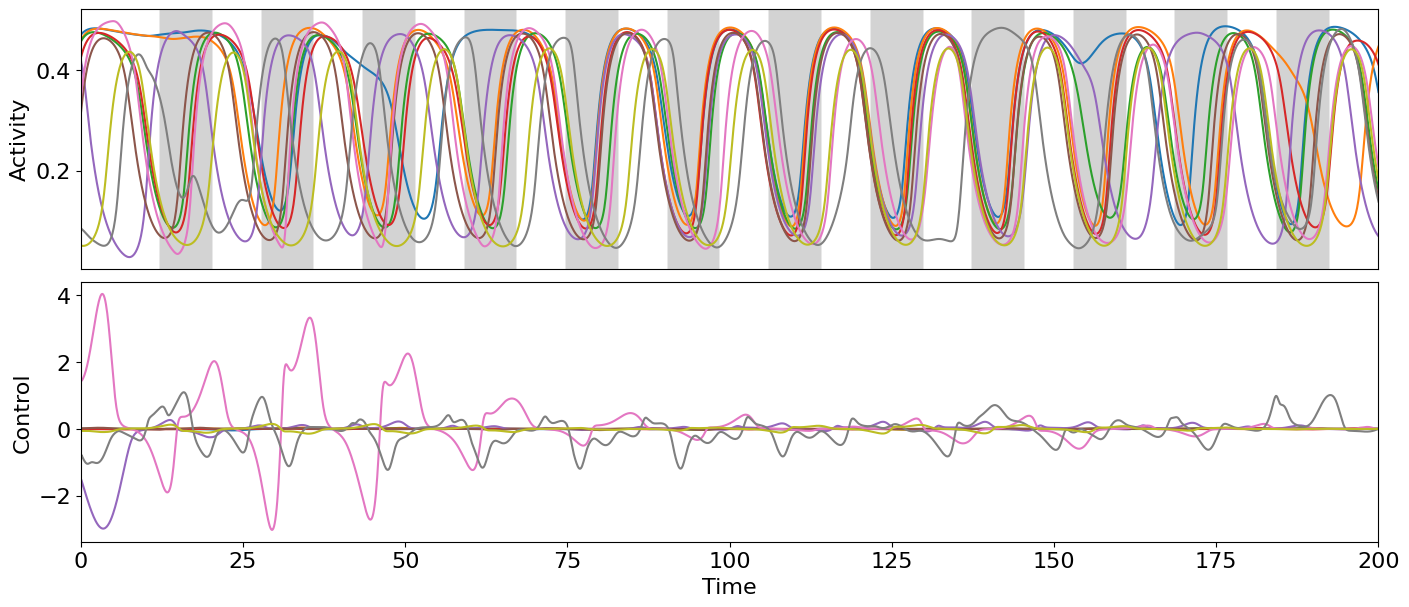

itar =  1
iw =  0
iw =  1
iw =  2
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -1.4281336725367755
Cost in iteration 10: -2.0007630228452866
Converged in iteration 20 with cost -2.2227308815098588
Final cost : -2.2227308815098588


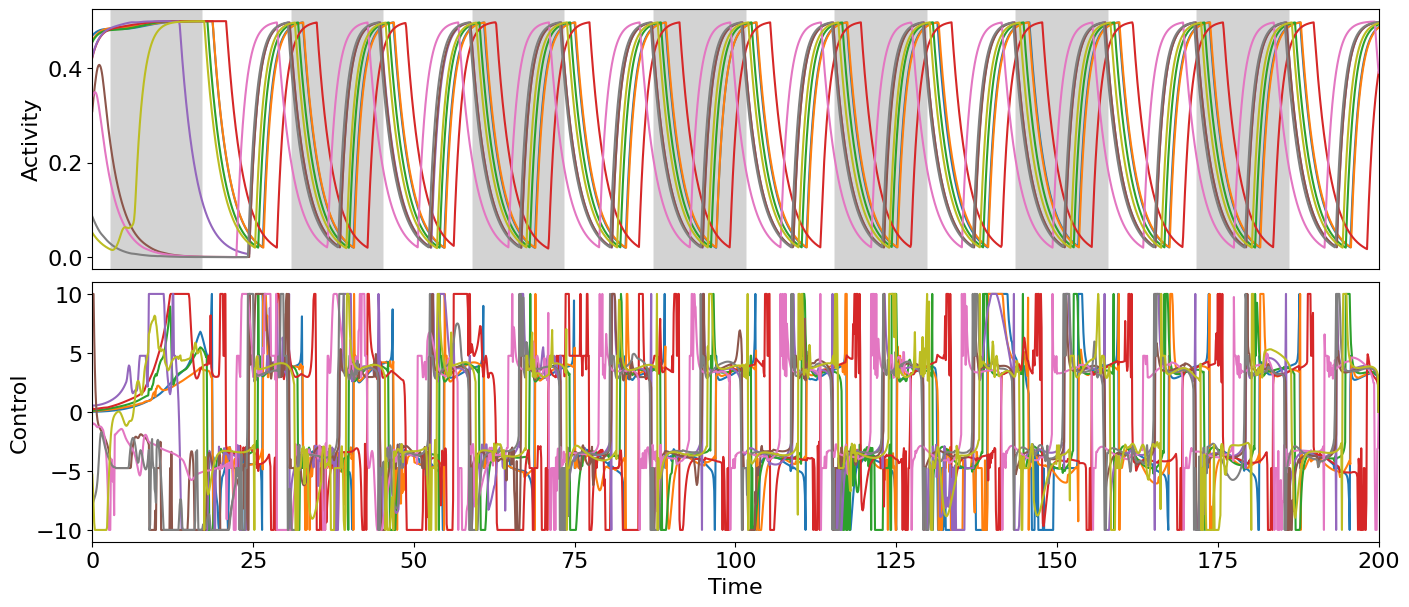

itar =  2
iw =  0
iw =  1
iw =  2
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -1.8701364643111538
Cost in iteration 10: -2.243793267705137
Converged in iteration 20 with cost -2.3078070405135116
Final cost : -2.3078070405135116


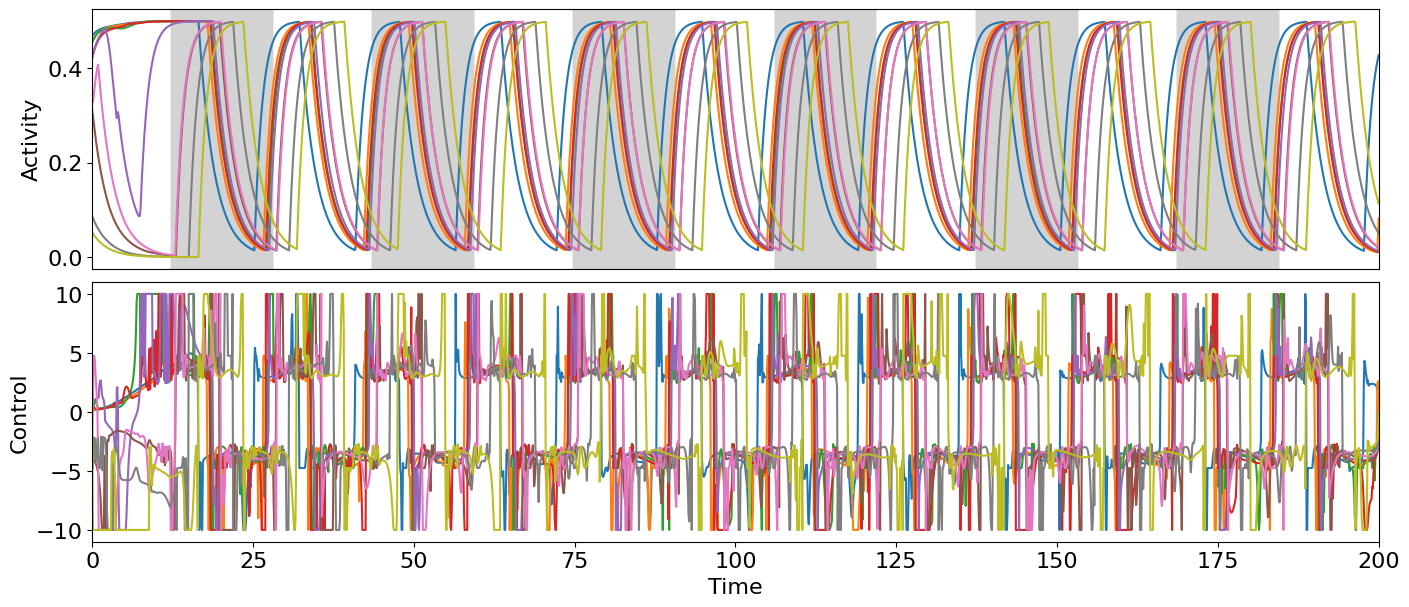

itar =  3
iw =  0
iw =  1
iw =  2
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -2.0915059290247155
Cost in iteration 10: -2.3023563244504177
Converged in iteration 20 with cost -2.377751458613215
Final cost : -2.377751458613215


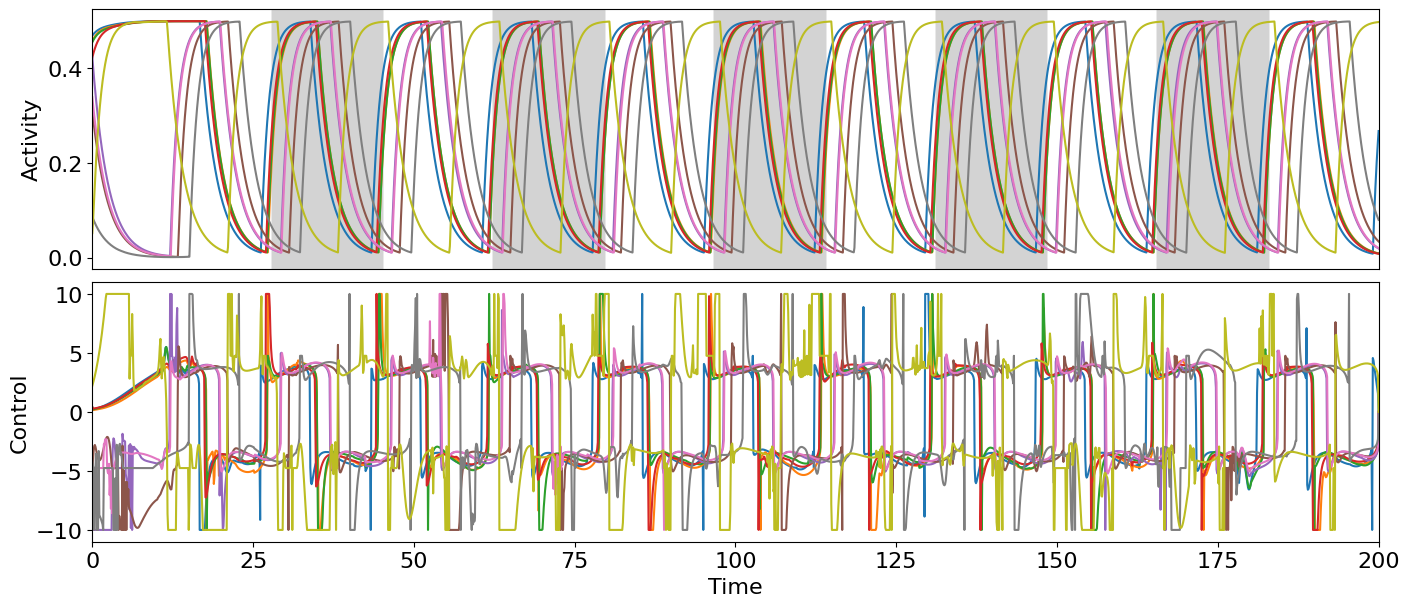

itar =  4
iw =  0
iw =  1
iw =  2
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -1.6386562736377366
Cost in iteration 10: -2.3179160345010015
Converged in iteration 20 with cost -2.5943903128177914
Final cost : -2.5943903128177914


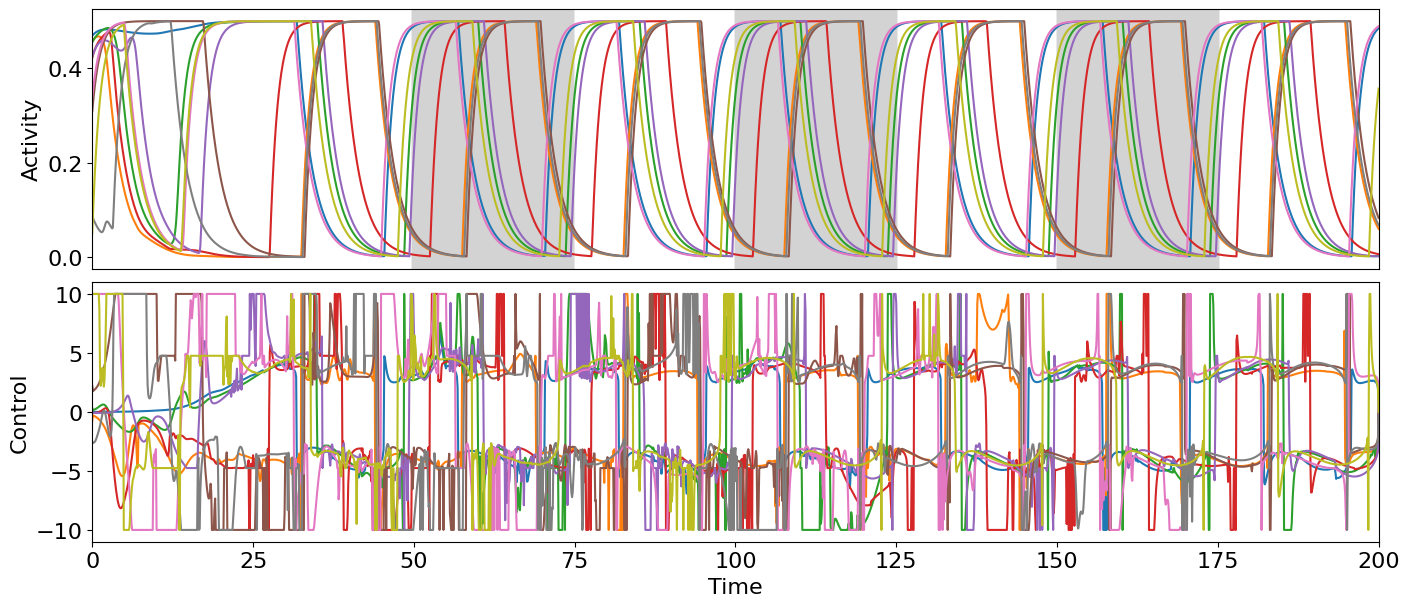

In [35]:
for pind in range(len(comp_points)):

    print("pind = ", pind)

    if pind not in [2]:
        continue

    p = comp_points[pind]
    
    testd = 1000.
    model.params.duration = testd
    test_input = ZeroInput().generate_input(duration=testd+model.params.dt, dt=model.params.dt)
    model.params["exc_ext"] = test_input + p[0]
    model.params["inh_ext"] = test_input + p[1]
    model.run()

    einit = np.zeros((N, nmaxdel+1))
    iinit = np.zeros((N, nmaxdel+1))


    for n in range(N):
        einit[n,:] = model.exc[n,-1]
        iinit[n,:] = model.inh[n,-1]

    model.params.duration = duration

    model.params["exc_ext"] = zero_control[:,0,:] + p[0]
    model.params["inh_ext"] = zero_control[:,0,:] + p[1]

    model.params["exc_init"] = einit
    model.params["inh_init"] = iinit

    model.run()

    for itar in range(len(target_array)):
        print("itar = ", itar)

        target_period = target_array[itar]
        i00 = 0
        int0 = np.around( (duration - i00 * target_period) / model.params.dt, 0).astype(int)     
        while int0 > 260:
            i00 += 1
            int0 = np.around( (duration - i00 * target_period) / model.params.dt, 0).astype(int)

        for iw in range(len(w2_array)):
            print("iw = ", iw)

            if iw not in [2]:
                continue
            
            model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), cost_matrix=costmat, control_matrix = controlmat)
            model_controlled.maximum_control_strength = maxstr
            model_controlled.weights["w_p"] = 0.
            model_controlled.weights["w_2"] = w2_array[iw]
            model_controlled.weights["w_f_pl"] = 1.
            
            if type(results["controls"][pind][itar][iw]) != type(None):
                model_controlled.control = results["controls"][pind][itar][iw].copy()
                model_controlled.update_input()

            model_controlled.optimize(it)
            results["controls"][pind][itar][iw] = model_controlled.control.copy()

            timings, periods = getperiods(model_controlled.get_xs(), proms[iw])
            results["timings"][pind][itar][iw] = timings
            results["periods"][pind][itar][iw] = periods

            fname = str(pind) + "_" + str(itar) + "_" + str(iw) + ".png"

            plot_oc_nw(N, duration, dt, model_controlled.get_xs(), target_period, model_controlled.control, filename= os.path.join(dir, fname))

In [36]:
with open('pl_9n_tol.pickle', 'wb') as f:
    pickle.dump(results, f)

In [8]:
with open('pl_9n_tol.pickle', 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

results = res_read.copy()

dict_keys(['controls', 'periods', 'timings'])


In [37]:
xl = ["Down F", "Up F", "Osc F"]

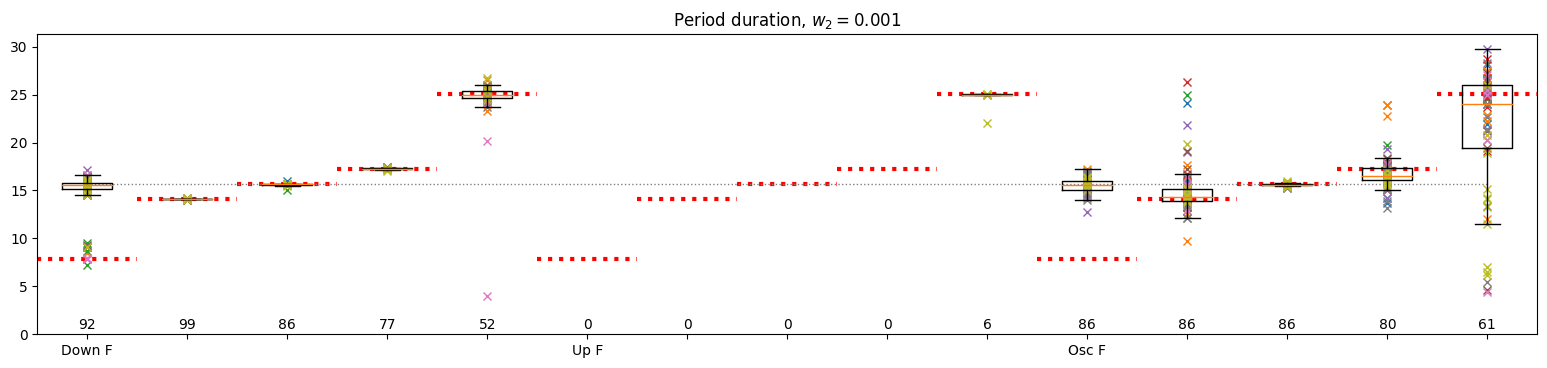

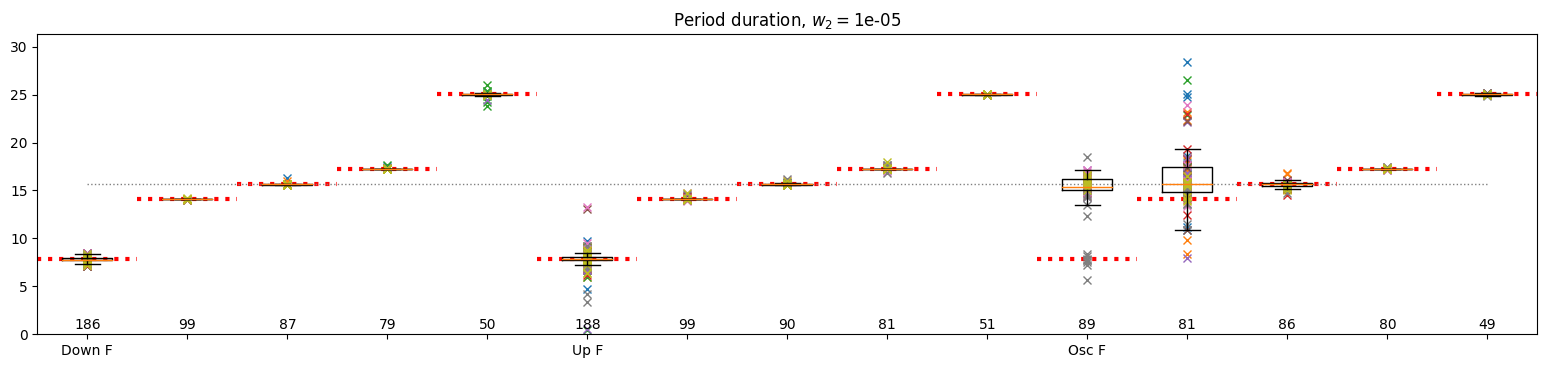

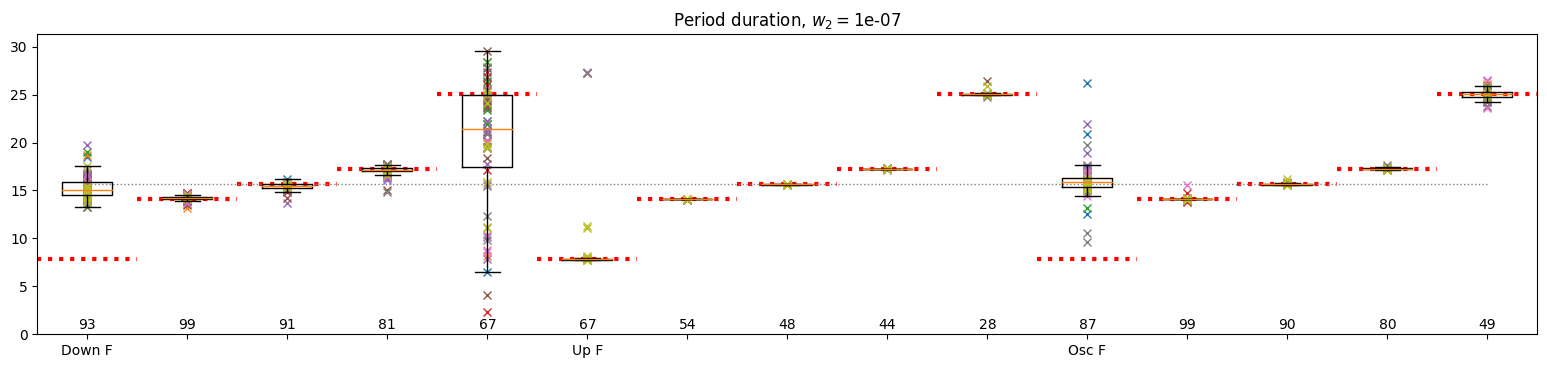

In [38]:
for iw in range(len(w2_array)):
    ydata = []
    xlabels = []
    fig = plt.figure(figsize =(15, 3))
    ax = fig.add_axes([0, 0, 1, 1])

    xpos = 0

    for pind in range(len(comp_points)):

        for itar in range(len(target_array)):

            target_period = target_array[itar]
            #xpos = 15*imet + 5*pind + itar 

            if itar != 0:
                    xlabels.append("")
            else:
                xlabels.append(xl[pind])

            data = results["periods"][pind][itar][iw]
            ydata_ = []
            
            if data is None:
                ydata.append(ydata_)
                continue

            n_datapoints = 0

            for n in range(N):
                n_datapoints += len(data[n])
                
                if len(data[n]) != 0:
                    for dpoint in data[n]:
                        ax.plot(xpos+1, dpoint, marker="x", color=colors[n])
                        ydata_.append(dpoint)

            ydata.append(ydata_)

            ax.text(xpos+1, 1, str(n_datapoints), horizontalalignment='center', verticalalignment='center')
            if xpos < 15: ax.hlines(target_period, xpos+0.5, xpos+1.5, linestyle=":", color="red", linewidth =3)

            xpos += 1


    ax.boxplot(ydata, showfliers=False)
    ax.hlines(period, 1., len(xlabels), linestyle=":", color="grey",linewidth = 1)
    ax.set_xticklabels(xlabels)
    ax.set_ylim(0., 2.*period)
    ax.set_title(r"Period duration, $w_2 = $" + "{}".format(w2_array[iw]))
    plt.show()
    fig.savefig(os.path.join(dir, "periods_" + str(iw) + ".png"), bbox_inches='tight')

9 [[], [], [], [], [], [], [], [], []]


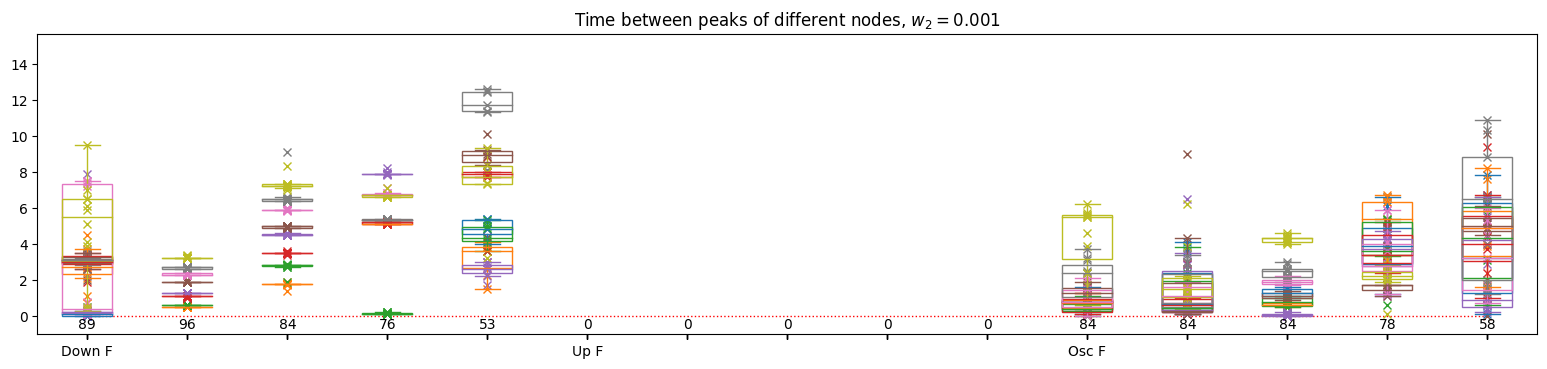

9 [[], [], [], [], [], [], [], [], []]


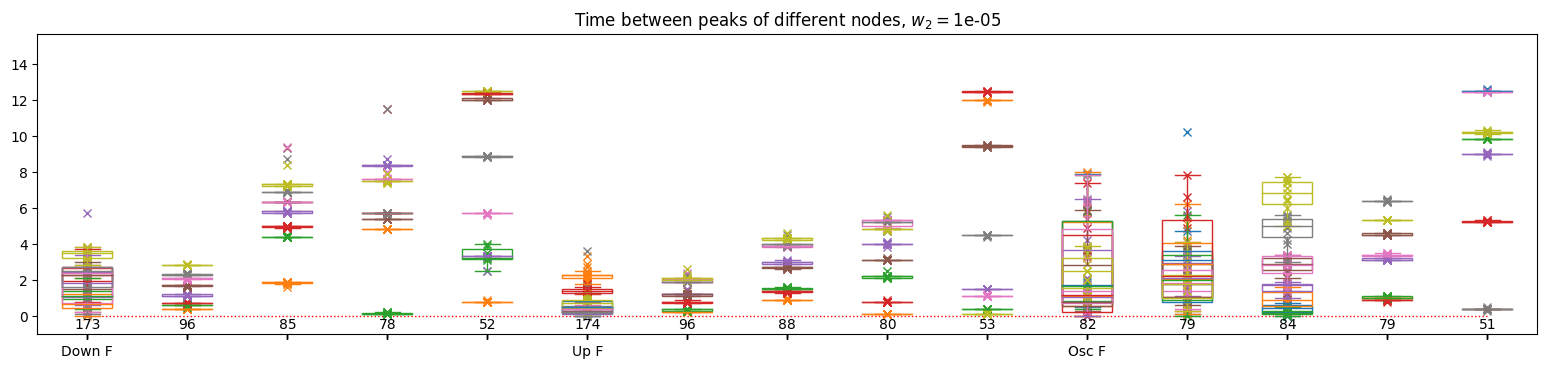

9 [[], [], [], [], [], [], [], [], []]


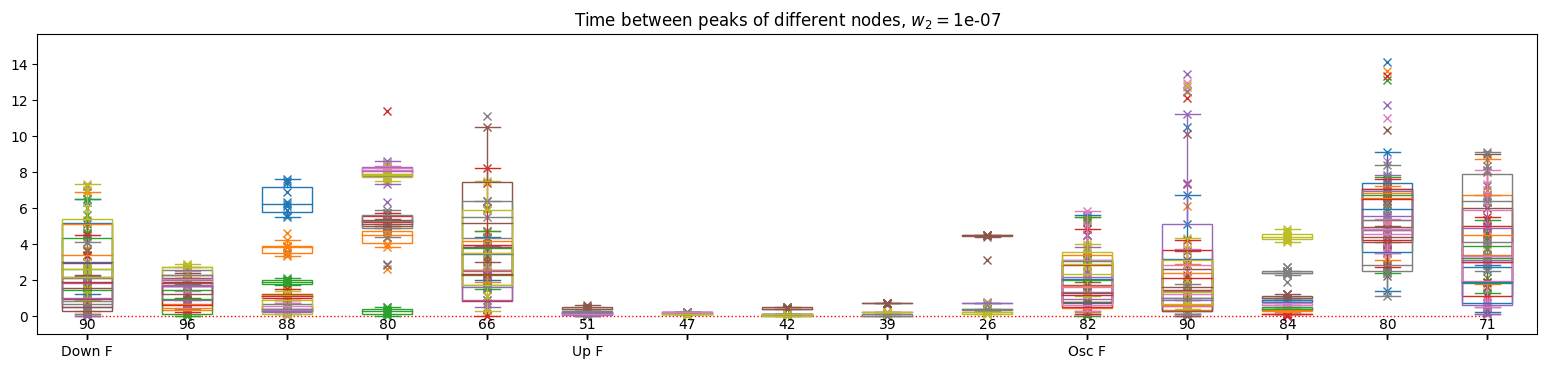

In [33]:
for iw in range(len(w2_array)):
    ydata = [[] for n in range(N) ]
    print(len(ydata), ydata)
    xlabels = []
    fig = plt.figure(figsize =(15, 3))
    ax = fig.add_axes([0, 0, 1, 1])
    xpos = 0

    for pind in range(len(comp_points)):

        for itar in range(len(target_array)):

            data = results["timings"][pind][itar][iw]

            if data is None:
                print("NONE")
                ydata.append(ydata_)
                continue

            n_maxpeaks = 0

            for n in range(1, N):
                if len(data[n]) > len(data[n_maxpeaks]):
                    n_maxpeaks = n

            n_datapoints = 0

            for n in range(N):
                ydata_ = []
                if n == n_maxpeaks:
                    ydata[n].append([])
                    continue
                
                n_datapoints += len(data[n])
                
                for p in data[n]:
                    dpoint = np.amin(np.abs(p - data[n_maxpeaks])) * dt
                    ydata_.append( dpoint )
                    ax.plot(xpos+1, dpoint, marker="x", color=colors[n])

                ydata[n].append(ydata_)

            ax.text(xpos+1, -0.5, str(n_datapoints), horizontalalignment='center', verticalalignment='center')
            if itar == 0:
                ax.text(xpos+1, -2, xl[pind], horizontalalignment='center', verticalalignment='center')
            xpos += 1

    for n in range(N):
        if len(ydata[n]) == 0: continue
        ax.boxplot(ydata[n], showfliers=False, patch_artist=True,
                   boxprops=dict(fill=None, facecolor="white", color=colors[n]),
                   whiskerprops=dict(color=colors[n]), capprops=dict(color=colors[n]), medianprops=dict(color=colors[n]))

    ax.hlines(0., 1., len(ydata[0]), linestyle=":", color="red",linewidth = 1)
    ax.set_xticklabels([])
    ax.set_ylim(-1., period)
    ax.set_title(r"Time between peaks of different nodes, $w_2 = $" + "{}".format(w2_array[iw]))
    plt.show()
    fig.savefig(os.path.join(dir, "timings_" + str(iw) + ".png"), bbox_inches='tight')